script to use the dalitz plot method outlined by matt shepard to calculate the efficiency of the kstar rejection in the KKPi phasespace

The idea would be to correct the data by this as opposed to the phasespace acceptance, as this just handles the K* rejection and not the overall efficiency (which may not actually model the f1 well, unlike the signal MC)

In [70]:
import ROOT
import numpy as np
import pandas as pd
from common_analysis_tools import get_integrated_data_hist, colorblind_hex_dict, get_integrated_gluex1_acceptance_corrected_data, get_integrated_gluex1_data

In [29]:
mass_low = 1.0 # GeV
mass_high = 2.5
step_size = 0.01


kstar_mass_upper = 1.0
kstar_mass_lower = 0.8

kaon_mass = 0.493677
kshort_mass = 0.497611
pion_mass = 0.139570


In [30]:
def check_if_kstar_region(mass):
    return mass < kstar_mass_upper and mass > kstar_mass_lower


def get_weight_per_mass(mass_bin, draw_plots=False):
    phasespace_centermass = ROOT.TLorentzVector(0, 0, 0, mass_bin)
    phasespace_generator = ROOT.TGenPhaseSpace()
    phasespace_generator.SetDecay(phasespace_centermass, 3, np.array([kaon_mass, kshort_mass, pion_mass]))

    total = 0
    passed = 0

    full_dalitz = ROOT.TH2D(f"dalitz_{mass_bin}", f"dalitz_{mass_bin}", 100, 0, 2, 100, 0, 2)
    passed_dalitz = ROOT.TH2D(f"passed_dalitz_{mass_bin}", f"passed_dalitz_{mass_bin}", 100, 0, 2, 100, 0, 2)

    for _ in range(100000):
        weight = phasespace_generator.Generate()
        kaon = phasespace_generator.GetDecay(0)
        kshort = phasespace_generator.GetDecay(1)
        pion = phasespace_generator.GetDecay(2)

        neutral_kstar_mass = (kaon + pion).M()
        charged_kstar_mass = (kshort + pion).M()

        full_dalitz.Fill(neutral_kstar_mass*neutral_kstar_mass, charged_kstar_mass*charged_kstar_mass, weight)
        total += weight

        if check_if_kstar_region(neutral_kstar_mass) or check_if_kstar_region(charged_kstar_mass):
            continue 

        passed_dalitz.Fill(neutral_kstar_mass*neutral_kstar_mass, charged_kstar_mass*charged_kstar_mass, weight)
        passed += weight

    if draw_plots:
        c = ROOT.TCanvas()
        c.Divide(2,1)
        c.cd(1)
        full_dalitz.Draw("colz")
        c.cd(2)
        passed_dalitz.Draw("colz")
        c.Update()
        c.SaveAs("/work/halld/home/viducic/plots/ps_dalitz/dalitz_{}.png".format(mass_bin))
        c.Close()


    return passed / total

In [67]:
mass_bin_centers = []
kstar_cut_efficiencies = []
for mass_bin in np.arange(mass_low, mass_high+step_size, step_size):
    mass_bin_center = round(mass_bin + (step_size/2), 3)
    binned_weight = get_weight_per_mass(mass_bin_center)
    mass_bin_centers.append(mass_bin_center)
    kstar_cut_efficiencies.append(binned_weight)


In [50]:
df = pd.DataFrame({"mass_bin_center": mass_bin_centers, "kstar_cut_efficiency": kstar_cut_efficiencies})
df['kstar_cut_efficiency'] = df['kstar_cut_efficiency'].fillna(1)
df.to_csv("/work/halld/home/viducic/data/ps_dalitz/kstar_cut_efficiency.csv", index=False)

In [68]:
def apply_efficiency_correction(hist):
    corrected_hist = hist.Clone()
    for i in range(1, corrected_hist.GetNbinsX()+1):
        mass_bin_center = round(hist.GetBinCenter(i),3)
        efficiency = df[df["mass_bin_center"] == round(mass_bin_center, 3)]["kstar_cut_efficiency"].values[0]
        corrected_hist.SetBinContent(i, hist.GetBinContent(i) / efficiency)
    
    corrected_hist.SetDirectory(0)

    return corrected_hist

In [101]:
hist = get_integrated_gluex1_data('pipkmks', 'all')
hist.SetLineColor(ROOT.TColor.GetColor(colorblind_hex_dict['blue']))
corrected_hist = apply_efficiency_correction(hist)
corrected_hist.SetLineColor(ROOT.TColor.GetColor(colorblind_hex_dict['red']))
uncut_hist = get_integrated_gluex1_data('pipkmks', "no")
uncut_hist.SetLineColor(ROOT.TColor.GetColor(colorblind_hex_dict['purple']))
uncut_hist.SetTitle("M(#pi^{+}K^{-}K_{s}) with and without K* rejection efficiency correction")
acceptance_corrected_hist = get_integrated_gluex1_acceptance_corrected_data('pipkmks', 'all')
acceptance_corrected_hist.SetLineColor(ROOT.TColor.GetColor(colorblind_hex_dict['green']))

acceptance_corrected_hist.Scale(1/44)

fit_range_min = 1.2
fit_range_max = 1.5
hist.GetXaxis().SetRangeUser(fit_range_min, fit_range_max)
uncut_hist.GetXaxis().SetRangeUser(fit_range_min, fit_range_max)
corrected_hist.GetXaxis().SetRangeUser(fit_range_min, fit_range_max)
acceptance_corrected_hist.GetXaxis().SetRangeUser(fit_range_min, fit_range_max)



filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2018_spring.root
filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2018_fall.root
filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2017.root
filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2018_spring.root
filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2018_fall.root
filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2017.root
filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2018_spring.root
filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2018_fall.root
filepath: /work/halld/home/viducic/data/pipkmks/data/bestX2/pipkmks_flat_result_2017.root
filepath: /work/halld/home/viducic/data/pipkmks/mc/phasespace/mc_pipkmks_phasespace_flat_result_2018_spring.root
filepath: /work/halld/home/viducic/data/p

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [75]:
legend = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
legend.AddEntry(hist, "K* rejection without correction", "l")
legend.AddEntry(corrected_hist, "K* rejection with correction", "l")
legend.AddEntry(uncut_hist, "No K* rejection", "l")
legend.AddEntry(acceptance_corrected_hist, "Acceptance corrected", "l")

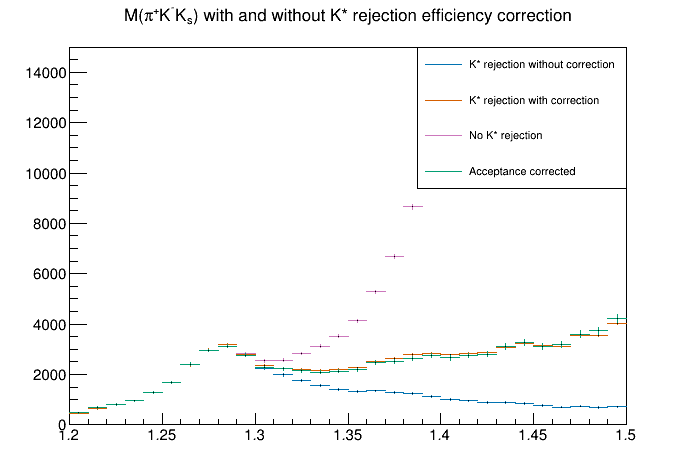

In [102]:
c1 = ROOT.TCanvas()
# uncut_hist.Draw()
hist.Draw()
corrected_hist.Draw("same")
acceptance_corrected_hist.Draw("same")
legend.Draw()
c1.Update()
c1.Draw()